In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

In [3]:
sdi_no_financial = pd.read_excel('./data/corr/sdi_비재무_total.xlsx')
sdi_no_financial = sdi_no_financial.loc[28:,:]
sdi_no_financial = sdi_no_financial.reset_index(drop=True)
del sdi_no_financial['회계년월']

In [5]:
sdi_stock_price = pd.read_excel('./data/sdi_stock_price.xlsx')

In [6]:
sdi = pd.merge(sdi_no_financial, sdi_stock_price, how = 'left', on = ['회사명', '거래소코드', '회계년도'])

In [7]:
sdi = sdi.dropna()

In [8]:
sdi

,회사명,거래소코드,회계년도,관계,성명,보통주식수(주),보통주식비율,우선주식수(주),우선주식비율,관리사무직_기말인원(남)(명),관리사무직_기말인원(여)(명),관리사무직_기말인원(명),관리사무직_년간평균급여(천원),관리사무직_1인년간평균급여(천원),생산직_기말인원(남)(명),생산직_기말인원(여)(명),생산직_기말인원(명),생산직_년간평균급여(천원),생산직_1인년간평균급여(천원),정규+무기계약_기말인원(남)(명),정규+무기계약_기말인원(여)(명),정규+무기계약_기말인원(명),정규+무기계약_년간평균급여(천원),정규+무기계약_1인년간평균급여(천원),기간제_기말인원(남)(명),기간제_기말인원(여)(명),기간제_기말인원(명),기간제_년간평균급여(천원),기간제_1인년간평균급여(천원),기타_기말인원(남)(명),기타_기말인원(여)(명),기타_기말인원(명),기타_년간평균급여(천원),기타_1인년간평균급여(천원),합계_기말인원(남)(명),합계_기말인원(여)(명),합계_기말인원(명),합계_년간평균급여(천원),합계_1인년간평균급여(천원),합계_평균근속연수,거래일수,최고가(원),최저가(원),산술평균(원),종가(원),거래량(주),거래대금(원)
0,삼성SDI(주),6400,2010/12,대주주 1인 총계,삼성전자외 6인,9324501,20.47,691,0.04,0,0,0,0,0,0,0,0,0,0,5443,917,6360,0,0,437,144,581,0,0,0,0,0,0,0,5880,1061,6941,480129000,69000,10.8,22.0,181000.0,161000.0,170886.0,168000.0,10389944.0,1.779555e+10
1,삼성SDI(주),6400,2011/03,대주주 1인 총계,삼성전자외 4인,9335779,20.49,691,0.04,0,0,0,0,0,0,0,0,0,0,5408,952,6360,0,0,447,162,609,0,0,0,0,0,0,0,5855,1114,6969,103191000,15000,10.5,22.0,178000.0,155000.0,166273.0,168000.0,12924052.0,2.146378e+10
2,삼성SDI(주),6400,2011/06,대주주 1인 총계,삼성전자외 4인,9314085,20.44,691,0.04,0,0,0,0,0,0,0,0,0,0,5597,946,6543,0,0,496,135,631,0,0,0,0,0,0,0,6093,1081,7174,208360000,29000,10.3,21.0,183500.0,155000.0,165190.0,163500.0,11360780.0,1.898625e+10
3,삼성SDI(주),6400,2011/09,대주주 1인 총계,삼성전자외 4인,9364754,20.56,691,0.04,0,0,0,0,0,0,0,0,0,0,5909,1077,6986,0,489,0,148,637,0,0,0,0,0,0,0,6398,1225,7623,312933000,41000,10.3,20.0,145000.0,99900.0,118275.0,116000.0,12380358.0,1.461671e+10
4,삼성SDI(주),6400,2011/12,대주주 1인 총계,삼성전자외 4인,9458410,20.76,693,0.04,0,0,0,0,0,0,0,0,0,0,5838,977,6815,0,0,418,135,553,0,0,0,0,0,0,0,6256,1112,7368,510682000,69000,10.5,21.0,153000.0,128000.0,137619.0,133500.0,8321983.0,1.151551e+10
5,삼성SDI(주),6400,2012/03,대주주 1인 총계,삼성전자외 5인,9405049,20.64,688,0.04,0,0,0,0,0,0,0,0,0,0,5835,973,6808,0,0,412,137,549,0,0,0,0,0,0,0,6247,1110,7357,130429000,18000,10.7,21.0,148000.0,134000.0,139810.0,137000.0,7046004.0,9.882485e+09
6,삼성SDI(주),6400,2012/06,대주주 1인 총계,삼성전자외 4인,9388766,20.61,684,0.04,0,0,0,0,0,0,0,0,0,0,5821,968,6789,0,0,490,140,630,0,0,0,0,0,0,0,6311,1108,7419,248593000,33000,10.5,20.0,160000.0,146000.0,152425.0,151500.0,4305587.0,6.578995e+09
7,삼성SDI(주),6400,2012/09,대주주 1인 총계,삼성전자외 5인,9357462,20.54,688,0.04,0,0,0,0,0,0,0,0,0,0,5792,967,6759,0,657,0,134,791,0,0,0,0,0,0,0,6449,1101,7550,363693000,48000,10.6,20.0,160000.0,139000.0,150000.0,158500.0,5584820.0,8.408558e+09
8,삼성SDI(주),6400,2012/12,대주주 1인 총계,삼성전자외 3인,9352658,20.53,684,0.04,0,0,0,0,0,0,0,0,0,0,5820,965,6785,0,0,566,135,701,0,0,0,0,0,0,0,6386,1100,7486,543124000,73000,9.8,18.0,157500.0,147500.0,153500.0,151000.0,2839042.0,4.342221e+09
9,삼성SDI(주),6400,2013/03,대주주 1인 총계,삼성전자외 4인,9355722,20.54,689,0.04,0,0,0,0,0,0,0,0,0,0,6617,1174,7791,0,0,725,142,867,0,0,0,0,0,0,0,7342,1316,8658,144140000,17000,11.1,20.0,143500.0,136500.0,140075.0,140500.0,3023089.0,4.245171e+09


# 상관관계

In [9]:
df_sdi = pd.DataFrame(sdi.corr()['종가(원)'].reset_index().sort_values('종가(원)', ascending = False))
df_sdi.columns = ['지표','종가']

In [10]:
df_sdi

,지표,종가
40,종가(원),1.000000
39,산술평균(원),0.970195
38,최저가(원),0.967548
37,최고가(원),0.966322
22,기간제_기말인원(명),0.584030
42,거래대금(원),0.458283
3,우선주식수(주),0.337889
4,우선주식비율,0.337066
20,기간제_기말인원(남)(명),0.304402
35,합계_평균근속연수,0.250569


# 변수 선정

In [12]:
deep_sdi = sdi[['기간제_기말인원(명)','정규+무기계약_기말인원(명)','거래대금(원)','우선주식수(주)','합계_평균근속연수','보통주식수(주)','종가(원)']]

# 정규화

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

# minmax_scale(nc_deep)
deep_sdi = pd.DataFrame(scale(deep_sdi))

# 샤비어 함수

In [14]:
def xavier_init(n_inputs, n_outputs, uniform=True):
    if uniform:
        # 6 was used in the paper.
        init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)
    else:
        # 3 gives us approximately the same limints as above since this repicks
        # values greater than 2 standard deviations from the mean.
        stddev = tf.sqrt(3.0 / (n_inputs + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

# 히든 레이어 5개

In [15]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.reset_default_graph()


x_data = deep_sdi.iloc[:-1,:-1]
y_data = deep_sdi.iloc[:-1,[-1]] # 괄호를 한번 더 씌어야 한다는 거 주의!!!!!!
print(y_data)
tf.set_random_seed(777)  # reproducibility
placeholder_num = len(x_data.columns)

# parameters
learning_rate = 0.001



X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([64]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[64, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

hypothesis = tf.matmul(L4, W5) + b5


# define cost/loss & optimizer
cost = tf.reduce_mean(tf.square(hypothesis - Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-5)
train = optimizer.minimize(cost)


# correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

           6
0   0.891150
1   0.891150
2   0.735571
3  -0.906648
4  -0.301620
5  -0.180614
6   0.320695
7   0.562706
8   0.303408
9  -0.059609
10 -0.197901
11  1.565324
12  0.683712
13  0.649139
14  0.683712
15 -0.681923
16 -0.906648
17 -0.197901
18 -1.079513
19 -1.165946
20 -0.975794
21 -1.494390
22 -1.183232
23 -1.598109
24 -1.148659
25 -0.197901
26  0.891150
27  1.945628


# epoch 150만번 - 실행 no! 한시간 걸려요!

In [23]:
# Launch the graph in a session.
sess = tf.Session()

# Initializes global variables in the graph.
sess.run(tf.global_variables_initializer())

       
for step in tqdm_notebook(range(1500001)):
    cost_val, hy_val, _ = sess.run([cost, hypothesis, train],
                                   feed_dict={X: x_data, Y: y_data, keep_prob: 1.0})

    if step % 10000 == 0 or step < 10 :
        print("\nStep : {} \nCost : {} \nPrediction :\n{}".format(step, cost_val, hy_val))


Step : 0 
Cost : 7.77529239654541 
Prediction :
[[-2.552742 ]
 [-2.531527 ]
 [-2.53584  ]
 [-2.6006577]
 [-2.6196156]
 [-2.6334352]
 [-2.701726 ]
 [-2.6921892]
 [-2.7937517]
 [-2.8071942]
 [-2.7684422]
 [-2.7207494]
 [-2.8178735]
 [-2.7819443]
 [-2.6790485]
 [-2.8514833]
 [-2.8187065]
 [-2.7243166]
 [-2.7372553]
 [-2.6959057]
 [-2.7574928]
 [-2.7860136]
 [-2.7935348]
 [-2.839107 ]
 [-2.7791114]
 [-2.7215414]
 [-2.7229822]
 [-2.6458378]]

Step : 1 
Cost : 7.73400354385376 
Prediction :
[[-2.5448227]
 [-2.523638 ]
 [-2.528009 ]
 [-2.5928497]
 [-2.6116924]
 [-2.6251566]
 [-2.6933298]
 [-2.6838803]
 [-2.7855704]
 [-2.798945 ]
 [-2.760204 ]
 [-2.7131143]
 [-2.810135 ]
 [-2.7741995]
 [-2.671399 ]
 [-2.8449214]
 [-2.8115668]
 [-2.716881 ]
 [-2.7297935]
 [-2.6882973]
 [-2.7501469]
 [-2.7780995]
 [-2.7858562]
 [-2.8314364]
 [-2.7714195]
 [-2.7135396]
 [-2.7150192]
 [-2.6379986]]

Step : 2 
Cost : 7.693082332611084 
Prediction :
[[-2.5369341]
 [-2.5157788]
 [-2.5202076]
 [-2.5850718]
 [-2.60379

 [ 0.6607939 ]]

Step : 90000 
Cost : 0.269326776266098 
Prediction :
[[ 0.6810163 ]
 [ 0.82860243]
 [ 0.6144351 ]
 [ 0.29346693]
 [ 0.05201578]
 [ 0.04551148]
 [-0.10155749]
 [ 0.27168727]
 [-0.43642324]
 [ 0.04610503]
 [ 0.34179652]
 [ 0.9343542 ]
 [ 0.60887825]
 [ 0.9309535 ]
 [ 1.1423248 ]
 [-1.0717363 ]
 [-1.3444989 ]
 [-0.7976952 ]
 [-0.8954818 ]
 [-0.52797997]
 [-0.89687   ]
 [-1.1322727 ]
 [-1.0337343 ]
 [-0.90956575]
 [-0.52796876]
 [-0.2288276 ]
 [ 0.22267723]
 [ 0.7437432 ]]

Step : 100000 
Cost : 0.2590937316417694 
Prediction :
[[ 0.6775857 ]
 [ 0.8195441 ]
 [ 0.6017151 ]
 [ 0.26952422]
 [ 0.01627636]
 [ 0.01234043]
 [-0.12231338]
 [ 0.26298392]
 [-0.47203386]
 [ 0.03718507]
 [ 0.3530593 ]
 [ 0.96333647]
 [ 0.6353729 ]
 [ 0.9576347 ]
 [ 1.1788915 ]
 [-1.0712421 ]
 [-1.3581986 ]
 [-0.7844976 ]
 [-0.8864282 ]
 [-0.5059248 ]
 [-0.899421  ]
 [-1.1563447 ]
 [-1.061724  ]
 [-0.945576  ]
 [-0.5428722 ]
 [-0.21615541]
 [ 0.26526618]
 [ 0.8201548 ]]

Step : 110000 
Cost : 0.2505680

 [ 1.2281333 ]]

Step : 260000 
Cost : 0.18841004371643066 
Prediction :
[[ 0.65988564]
 [ 0.8159492 ]
 [ 0.51812756]
 [ 0.09328902]
 [-0.17149615]
 [-0.0688988 ]
 [-0.0722093 ]
 [ 0.25943172]
 [-0.40810663]
 [-0.00950301]
 [ 0.2692523 ]
 [ 1.0669271 ]
 [ 0.60666144]
 [ 0.9850948 ]
 [ 1.3621873 ]
 [-1.0479808 ]
 [-1.343834  ]
 [-0.77154416]
 [-0.8726466 ]
 [-0.5081328 ]
 [-0.92755127]
 [-1.2325268 ]
 [-1.1796548 ]
 [-1.1119375 ]
 [-0.6181991 ]
 [-0.2309717 ]
 [ 0.53684974]
 [ 1.2428445 ]]

Step : 270000 
Cost : 0.18471786379814148 
Prediction :
[[ 0.65849173]
 [ 0.8181964 ]
 [ 0.5157794 ]
 [ 0.0841893 ]
 [-0.17376637]
 [-0.06949407]
 [-0.0648942 ]
 [ 0.25877953]
 [-0.39710146]
 [-0.01095158]
 [ 0.26072133]
 [ 1.0692748 ]
 [ 0.5976294 ]
 [ 0.9771179 ]
 [ 1.3676833 ]
 [-1.0441805 ]
 [-1.3389615 ]
 [-0.772957  ]
 [-0.8731802 ]
 [-0.51278687]
 [-0.9280578 ]
 [-1.2325928 ]
 [-1.1850395 ]
 [-1.1181378 ]
 [-0.6235354 ]
 [-0.23524034]
 [ 0.5496464 ]
 [ 1.261824  ]]

Step : 280000 
Cost : 0.181

 [ 1.4726292 ]]

Step : 430000 
Cost : 0.1336834877729416 
Prediction :
[[ 0.64003193]
 [ 0.84564364]
 [ 0.4911288 ]
 [-0.03731191]
 [-0.21694273]
 [-0.0804739 ]
 [ 0.05710852]
 [ 0.29713094]
 [-0.20401138]
 [-0.02966368]
 [ 0.17262721]
 [ 1.1012279 ]
 [ 0.5375358 ]
 [ 0.9309895 ]
 [ 1.3675097 ]
 [-0.96293056]
 [-1.25209   ]
 [-0.77730554]
 [-0.8496188 ]
 [-0.6190623 ]
 [-0.94728094]
 [-1.2468256 ]
 [-1.2828786 ]
 [-1.2302749 ]
 [-0.7329206 ]
 [-0.33875334]
 [ 0.7260181 ]
 [ 1.4844865 ]]

Step : 440000 
Cost : 0.13100461661815643 
Prediction :
[[ 0.6376722 ]
 [ 0.84609926]
 [ 0.48950303]
 [-0.04467964]
 [-0.21912414]
 [-0.08093512]
 [ 0.06263423]
 [ 0.29926443]
 [-0.19064552]
 [-0.03282392]
 [ 0.1665535 ]
 [ 1.1018893 ]
 [ 0.5338609 ]
 [ 0.9274695 ]
 [ 1.3657261 ]
 [-0.958022  ]
 [-1.2453896 ]
 [-0.7769738 ]
 [-0.8471731 ]
 [-0.6223191 ]
 [-0.9485234 ]
 [-1.2487621 ]
 [-1.2905138 ]
 [-1.2411007 ]
 [-0.73747194]
 [-0.34068072]
 [ 0.7385824 ]
 [ 1.4989661 ]]

Step : 450000 
Cost : 0.1283

 [ 1.660699  ]]

Step : 610000 
Cost : 0.09148891270160675 
Prediction :
[[ 0.61641955]
 [ 0.8739064 ]
 [ 0.48759806]
 [-0.1600725 ]
 [-0.24764407]
 [-0.0842731 ]
 [ 0.16001356]
 [ 0.33612168]
 [ 0.0434351 ]
 [-0.09164917]
 [ 0.05681944]
 [ 1.1291016 ]
 [ 0.51104367]
 [ 0.88749814]
 [ 1.2740182 ]
 [-0.85428625]
 [-1.1237388 ]
 [-0.7777172 ]
 [-0.82152814]
 [-0.69828904]
 [-0.9495916 ]
 [-1.279228  ]
 [-1.3835928 ]
 [-1.3858821 ]
 [-0.8607863 ]
 [-0.36633015]
 [ 0.8892287 ]
 [ 1.66791   ]]

Step : 620000 
Cost : 0.08958351612091064 
Prediction :
[[ 0.61611104]
 [ 0.87647855]
 [ 0.48810315]
 [-0.16696048]
 [-0.24966598]
 [-0.084674  ]
 [ 0.1655724 ]
 [ 0.3387556 ]
 [ 0.05697477]
 [-0.09405184]
 [ 0.05121636]
 [ 1.1315712 ]
 [ 0.5129409 ]
 [ 0.8864714 ]
 [ 1.2651278 ]
 [-0.8486852 ]
 [-1.1168814 ]
 [-0.7780215 ]
 [-0.82051873]
 [-0.7023338 ]
 [-0.9495245 ]
 [-1.2811455 ]
 [-1.388371  ]
 [-1.3939075 ]
 [-0.8674441 ]
 [-0.36934674]
 [ 0.89574516]
 [ 1.6748413 ]]

Step : 630000 
Cost : 0.087

 [ 1.7662991 ]]

Step : 780000 
Cost : 0.0633000060915947 
Prediction :
[[ 0.62790143]
 [ 0.9250406 ]
 [ 0.49474525]
 [-0.30555785]
 [-0.27822137]
 [-0.08906329]
 [ 0.24755645]
 [ 0.38385522]
 [ 0.22104204]
 [-0.13115847]
 [-0.03035057]
 [ 1.1717166 ]
 [ 0.5452317 ]
 [ 0.87773275]
 [ 1.094047  ]
 [-0.76774246]
 [-1.0189407 ]
 [-0.77824783]
 [-0.8193231 ]
 [-0.7560148 ]
 [-0.9370959 ]
 [-1.3042657 ]
 [-1.4327369 ]
 [-1.4908727 ]
 [-0.9722958 ]
 [-0.37037873]
 [ 0.97230697]
 [ 1.771521  ]]

Step : 790000 
Cost : 0.0619015134871006 
Prediction :
[[ 0.6299398 ]
 [ 0.9285661 ]
 [ 0.49519873]
 [-0.31592745]
 [-0.27876365]
 [-0.08871126]
 [ 0.25178218]
 [ 0.3882327 ]
 [ 0.22794783]
 [-0.13412178]
 [-0.03535056]
 [ 1.1747206 ]
 [ 0.5470624 ]
 [ 0.8776684 ]
 [ 1.0828341 ]
 [-0.7630442 ]
 [-1.014389  ]
 [-0.7789842 ]
 [-0.82043433]
 [-0.75937235]
 [-0.93598276]
 [-1.3051499 ]
 [-1.433285  ]
 [-1.4944363 ]
 [-0.97957826]
 [-0.36825883]
 [ 0.97560334]
 [ 1.7765082 ]]

Step : 800000 
Cost : 0.06053

 [ 1.82454   ]]

Step : 960000 
Cost : 0.04323618859052658 
Prediction :
[[ 0.6923386 ]
 [ 0.9951638 ]
 [ 0.5162319 ]
 [-0.49545908]
 [-0.30759835]
 [-0.09664547]
 [ 0.3055514 ]
 [ 0.44114792]
 [ 0.3091979 ]
 [-0.17005861]
 [-0.08714187]
 [ 1.2408694 ]
 [ 0.5815723 ]
 [ 0.8778    ]
 [ 0.90596855]
 [-0.6983793 ]
 [-0.9550212 ]
 [-0.78698945]
 [-0.84049153]
 [-0.8076674 ]
 [-0.92321205]
 [-1.3186462 ]
 [-1.4307128 ]
 [-1.5328617 ]
 [-1.0823834 ]
 [-0.3141893 ]
 [ 1.0041746 ]
 [ 1.8267716 ]]

Step : 970000 
Cost : 0.04244687780737877 
Prediction :
[[ 0.6960486 ]
 [ 0.99867475]
 [ 0.51781595]
 [-0.5051851 ]
 [-0.30963147]
 [-0.09745204]
 [ 0.30755568]
 [ 0.44375682]
 [ 0.31211782]
 [-0.17145467]
 [-0.08869004]
 [ 1.245098  ]
 [ 0.5831746 ]
 [ 0.8778093 ]
 [ 0.8969897 ]
 [-0.69565463]
 [-0.9527421 ]
 [-0.7871401 ]
 [-0.8419159 ]
 [-0.80991143]
 [-0.9226303 ]
 [-1.3195546 ]
 [-1.4299521 ]
 [-1.534155  ]
 [-1.0868092 ]
 [-0.31042373]
 [ 1.0045613 ]
 [ 1.8289248 ]]

Step : 980000 
Cost : 0.041

 [ 1.8550566 ]]

Step : 1140000 
Cost : 0.03195223584771156 
Prediction :
[[ 0.7545804 ]
 [ 1.007783  ]
 [ 0.5762985 ]
 [-0.629356  ]
 [-0.35518277]
 [-0.11752307]
 [ 0.33280432]
 [ 0.49854505]
 [ 0.32761788]
 [-0.12874436]
 [-0.16847849]
 [ 1.3243273 ]
 [ 0.59631646]
 [ 0.87195134]
 [ 0.7958554 ]
 [-0.6661793 ]
 [-0.92501295]
 [-0.78858536]
 [-0.84846216]
 [-0.84198636]
 [-0.9154285 ]
 [-1.3309941 ]
 [-1.4175998 ]
 [-1.550267  ]
 [-1.1331155 ]
 [-0.25581408]
 [ 0.9800217 ]
 [ 1.8562669 ]]

Step : 1150000 
Cost : 0.03153596818447113 
Prediction :
[[ 0.7560108 ]
 [ 1.0077194 ]
 [ 0.5802187 ]
 [-0.63418734]
 [-0.3576926 ]
 [-0.11845589]
 [ 0.33487785]
 [ 0.50142825]
 [ 0.3248247 ]
 [-0.12676609]
 [-0.17183363]
 [ 1.329472  ]
 [ 0.59657145]
 [ 0.87099504]
 [ 0.79115736]
 [-0.6664121 ]
 [-0.92454445]
 [-0.78849536]
 [-0.8484464 ]
 [-0.8438054 ]
 [-0.9150749 ]
 [-1.3309721 ]
 [-1.4158427 ]
 [-1.5504735 ]
 [-1.1339599 ]
 [-0.25402856]
 [ 0.9794785 ]
 [ 1.8577434 ]]

Step : 1160000 
Cost : 0.

 [ 1.8881034 ]]

Step : 1320000 
Cost : 0.02655142918229103 
Prediction :
[[ 0.77864754]
 [ 1.0123965 ]
 [ 0.61868596]
 [-0.7043576 ]
 [-0.387035  ]
 [-0.12516248]
 [ 0.3432305 ]
 [ 0.51845455]
 [ 0.33009267]
 [-0.11101806]
 [-0.18958879]
 [ 1.400011  ]
 [ 0.6028141 ]
 [ 0.8475034 ]
 [ 0.72468746]
 [-0.6649488 ]
 [-0.9100766 ]
 [-0.7828388 ]
 [-0.84653497]
 [-0.86724156]
 [-0.9141313 ]
 [-1.334166  ]
 [-1.3937626 ]
 [-1.5698646 ]
 [-1.145563  ]
 [-0.23616433]
 [ 0.9630847 ]
 [ 1.8895992 ]]

Step : 1330000 
Cost : 0.026331886649131775 
Prediction :
[[ 0.7797563 ]
 [ 1.0115842 ]
 [ 0.62049234]
 [-0.7071167 ]
 [-0.38772762]
 [-0.12479258]
 [ 0.34335506]
 [ 0.5185152 ]
 [ 0.33010352]
 [-0.11039543]
 [-0.1897155 ]
 [ 1.4033073 ]
 [ 0.6029941 ]
 [ 0.8457811 ]
 [ 0.7224784 ]
 [-0.6650822 ]
 [-0.9099455 ]
 [-0.78239673]
 [-0.84643614]
 [-0.86829317]
 [-0.9140017 ]
 [-1.3346947 ]
 [-1.3922853 ]
 [-1.5704271 ]
 [-1.1458814 ]
 [-0.2354095 ]
 [ 0.9618424 ]
 [ 1.8910578 ]]

Step : 1340000 
Cost : 0

 [ 1.9133314 ]]

Step : 1500000 
Cost : 0.02297334186732769 
Prediction :
[[ 0.79687536]
 [ 0.99412715]
 [ 0.6496799 ]
 [-0.7494876 ]
 [-0.39892662]
 [-0.11956918]
 [ 0.34508038]
 [ 0.52468514]
 [ 0.32888925]
 [-0.10157013]
 [-0.1904118 ]
 [ 1.4520859 ]
 [ 0.606657  ]
 [ 0.81638646]
 [ 0.69324636]
 [-0.66337764]
 [-0.9034757 ]
 [-0.77564365]
 [-0.8468626 ]
 [-0.8963087 ]
 [-0.9066645 ]
 [-1.3426707 ]
 [-1.3673946 ]
 [-1.5803553 ]
 [-1.1500459 ]
 [-0.2241193 ]
 [ 0.9412427 ]
 [ 1.914615  ]]



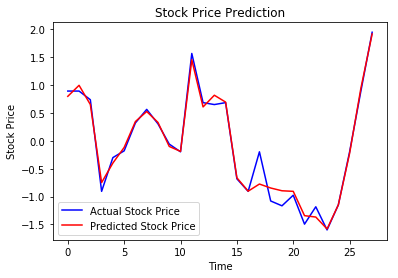

In [37]:
plt.plot((deep_sdi.iloc[:-1,[-1]]), color = 'blue', label = 'Actual Stock Price')
plt.plot((hy_val), color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Step : 9 
Cost : 7.949605464935303 
Prediction :
[[-2.4803991]
 [-2.4595096]
 [-2.464351 ]
 [-2.529332 ]
 [-2.5472245]
 [-2.5602655]
 [-2.6250741]
 [-2.6169748]
 [-2.7190568]
 [-2.7318287]
 [-2.693141 ]
 [-2.6510437]
 [-2.7472177]
 [-2.7112002]
 [-2.6092038]
 [-2.7914479]
 [-2.7535706]
 [-2.6563869]
 [-2.6690865]
 [-2.6263437]
 [-2.690434 ]
 [-2.7137372]
 [-2.7234678]
 [-2.7691169]
 [-2.70887  ]
 [-2.6483755]
 [-2.6501806]
 [-2.5741558]
 [-2.6685524]]
 
 

Step : 10000 
Cost : 0.7701790928840637 
Prediction :
[[ 0.34846377]
 [ 0.34557223]
 [ 0.29928517]
 [ 0.23050332]
 [ 0.23689497]
 [ 0.2519641 ]
 [ 0.18534923]
 [ 0.20576525]
 [ 0.07221937]
 [ 0.07065177]
 [ 0.1506269 ]
 [ 0.07123411]
 [-0.02706563]
 [ 0.06210053]
 [ 0.15942359]
 [-0.60165894]
 [-0.48857832]
 [-0.221196  ]
 [-0.2324484 ]
 [-0.1544708 ]
 [-0.3218313 ]
 [-0.19951326]
 [-0.22703028]
 [-0.29918098]
 [-0.0679599 ]
 [ 0.03205371]
 [ 0.06131601]
 [ 0.14758337]
 [ 0.07528329]]


Step : 100000 
Cost : 0.290214478969574 
Prediction :
[[ 0.69391704]
 [ 0.7738811 ]
 [ 0.51270306]
 [ 0.16896081]
 [-0.07477498]
 [-0.03195447]
 [-0.1383931 ]
 [ 0.27811408]
 [-0.5632342 ]
 [ 0.13358188]
 [ 0.4791    ]
 [ 0.9951165 ]
 [ 0.71186817]
 [ 1.1392186 ]
 [ 1.3596401 ]
 [-1.1284256 ]
 [-1.4151765 ]
 [-0.71919495]
 [-0.8188532 ]
 [-0.41124606]
 [-0.92249626]
 [-1.1857979 ]
 [-1.1004328 ]
 [-0.98291457]
 [-0.44676912]
 [-0.02941751]
 [ 0.5802771 ]
 [ 1.1945453 ]
 [ 0.93260705]]
 

Step : 2000000 
Cost : 0.022485418245196342 
Prediction :
[[ 0.82057834]
 [ 0.96881366]
 [ 0.65422344]
 [-0.80288327]
 [-0.37092173]
 [-0.10241461]
 [ 0.37002337]
 [ 0.49208522]
 [ 0.32639647]
 [-0.12920094]
 [-0.15728927]
 [ 1.4567885 ]
 [ 0.48257768]
 [ 0.95508885]
 [ 0.68574464]
 [-0.6632664 ]
 [-0.88565433]
 [-0.6918719 ]
 [-0.7670036 ]
 [-0.96188664]
 [-0.9977553 ]
 [-1.5031288 ]
 [-1.2392309 ]
 [-1.5861392 ]
 [-1.1189625 ]
 [-0.2744894 ]
 [ 1.093523  ]
 [ 1.9200306 ]
 [ 2.025856  ]]

실제값

[[ 0.79687536],
[ 0.99412715],
[ 0.6496799 ],
[-0.7494876 ],
[-0.39892662],
[-0.11956918],
[ 0.34508038],
[ 0.52468514],
[ 0.32888925],
[-0.10157013],
[-0.1904118 ],
[ 1.4520859 ],
[ 0.606657  ],
[ 0.81638646],
[ 0.69324636],
[-0.66337764],
[-0.9034757 ],
[-0.77564365],
[-0.8468626 ],
[-0.8963087 ],
[-0.9066645 ],
[-1.3426707 ],
[-1.3673946 ],
[-1.5803553 ],
[-1.1500459 ],
[-0.2241193 ],
[ 0.9412427 ],
[ 1.914615  ]]

# Validation - 29분기로 테스트

In [49]:
x_data1 = deep_sdi.iloc[[-1],:-1]
y_data1 = deep_sdi.iloc[-1,[-1]]

In [50]:
x_data1

,0,1,2,3,4,5
28,0.481002,0.198933,0.240787,-0.077981,1.661228,1.025784


In [57]:
hy_val1 = sess.run([hypothesis], feed_dict={X: x_data1, keep_prob: 1.0})

In [58]:
# 예측값
hy_val1 

[array([[0.9763174]], dtype=float32)]

In [59]:
# 실제값
y_data1

6    2.153066
Name: 28, dtype: float64